<a href="https://colab.research.google.com/github/quockhanhdao/Lung_Tumours_Segmentation/blob/main/Lung_Cancer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached einops-0.6.0-py3-none-any.whl (41 kB)


In [ ]:
!pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite, einops]"

In [ ]:
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
!pip install einops0
!python -c "import monai" || pip install 'monai[all]'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement einops0 (from versions: none)
ERROR: No matching distribution found for einops0
2023-04-15 04:47:21.772014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 04:47:26.813616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import libraries

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import monai
from monai.networks.nets import UNETR

from monai.apps import DecathlonDataset
from monai.data import DataLoader, CacheDataset, decollate_batch
from monai.utils import first, set_determinism
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    LoadImage, 
    LoadImageD, 
    EnsureChannelFirstD, 
    AddChannelD, 
    ScaleIntensityD, 
    ToTensorD, 
    Compose, 
    AsDiscreteD, 
    SpacingD, 
    OrientationD, 
    ResizeD, 
    RandAffineD,
    AsDiscrete,
    AsDiscreted,
    EnsureTyped,
    EnsureType,
)

import torch
import numpy as np
import matplotlib.pyplot as plt

print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


In [ ]:
cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
num_workers = 4 if cuda else 0

print('You are using gpu if true, cpu if false:', cuda)

You are using gpu if true, cpu if false: True


# Load data

## Test data

In [ ]:
# Dowload data, src: http://medicaldecathlon.com/
dataset = DecathlonDataset(root_dir = "./", 
                           task = "Task06_Lung", section = "training", 
                           transform = None, download = True)
print(f"\nnumber of subjects: {len(dataset)}.\nThe first element in the dataset is {dataset[0]}.")

Task06_Lung.tar: 8.53GB [08:39, 17.7MB/s]                            


2023-04-15 04:56:21,561 - INFO - Downloaded: Task06_Lung.tar
2023-04-15 04:57:00,460 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2023-04-15 04:57:00,464 - INFO - Writing into directory: ..


Loading dataset: 100%|██████████| 51/51 [00:00<00:00, 225167.90it/s]


number of subjects: 51.
The first element in the dataset is {'image': 'Task06_Lung/imagesTr/lung_014.nii.gz', 'label': 'Task06_Lung/labelsTr/lung_014.nii.gz'}.


In [ ]:
# Load random to check
loader = LoadImageD(keys=("image", "label"))
data_check = loader({"image": "Task06_Lung/imagesTr/lung_014.nii.gz", 
                     "label": "Task06_Lung/labelsTr/lung_014.nii.gz"})
print(f"image shape: {data_check['image'].shape} \nlabel shape: {data_check['label'].shape}")

image shape: torch.Size([512, 512, 589]) 
label shape: torch.Size([512, 512, 589])


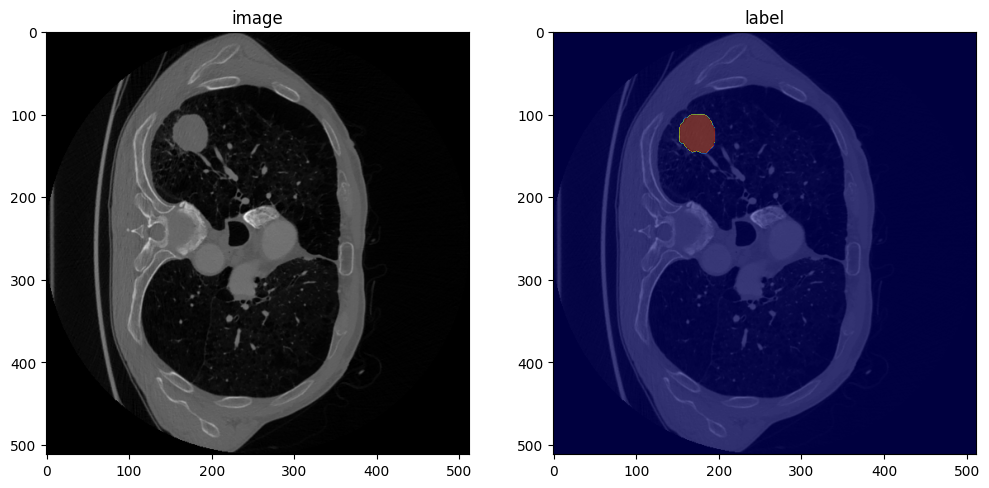

In [ ]:
# Visualize check image and label
slide = 379
plt.figure("check", (12, 6))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(data_check['image'][:, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(data_check['image'][:, :, slide], cmap = "gray")
plt.imshow(data_check['label'][:, :, slide], cmap = 'jet', alpha = 0.5)

plt.show()

## Load training set

In [ ]:
# Set up transform
KEYS = ["image", "label"]
transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys = KEYS, 
             pixdim = (1., 1., 1.), 
             mode = ('bilinear', 'nearest')),
    ScaleIntensityD(keys = "image"),
    ResizeD(KEYS, 
            (128, 128, 64), 
            mode=('trilinear', 'nearest')),
    RandAffineD(keys = KEYS, 
                spatial_size = (128, 128, 64),
                rotate_range = (0, 0, np.pi/12),
                scale_range = (0.1, 0.1, 0.1),
                mode = ('bilinear', 'nearest'),
                prob = 1.0),
    ToTensorD(KEYS),
])

In [ ]:
from monai.transforms.intensity.dictionary import ScaleIntensityRanged
# Change Transforms here
KEYS = ["image", "label"]
transform = Compose([
    LoadImageD(keys=KEYS),
    EnsureChannelFirstD(keys=KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys=KEYS, pixdim=(1., 1., 1.), mode=('bilinear', 'nearest')),
    ScaleIntensityRanged(keys="image", a_min=-1000, a_max=500, b_min=0.0, b_max=1.0, clip=True),
    ResizeD(KEYS, (128, 128, 64), mode=('trilinear', 'nearest')),
    RandAffineD(keys=KEYS,
                spatial_size=(128, 128, 64),
                prob=0.5,
                rotate_range=(np.pi/12, np.pi/12, np.pi/12),
                shear_range=(0.1, 0.1, 0.1),
                translate_range=(10, 10, 10),
                scale_range=(0.1, 0.1, 0.1),
                mode=('bilinear', 'nearest')),
    ToTensorD(KEYS),
])


In [ ]:
# Load data
dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "training",
                           transform = transform, download = True)

train_loader = DataLoader(dataset, batch_size = 1, shuffle = True, num_workers = 4)

2023-04-15 05:09:22,658 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2023-04-15 05:09:22,660 - INFO - File exists: Task06_Lung.tar, skipped downloading.
2023-04-15 05:09:22,664 - INFO - Non-empty folder exists in Task06_Lung, skipped extracting.


Loading dataset: 100%|██████████| 51/51 [12:39<00:00, 14.90s/it]


In [ ]:
# Check transformed data
print(f"Length of training set: {len(train_loader)}")

check_training = first(train_loader)
training_image, training_label = check_training['image'], check_training['label']
print(f"check data training image shape: {training_image.shape} \ncheck data training label shape: {training_label.shape}")

# Trying to understand what the dimension 2 of the data is
print(training_image[0, :, 0, 0, 39])

Length of training set: 51
check data training image shape: torch.Size([1, 1, 128, 128, 64]) 
check data training label shape: torch.Size([1, 1, 128, 128, 64])
metatensor([0.])


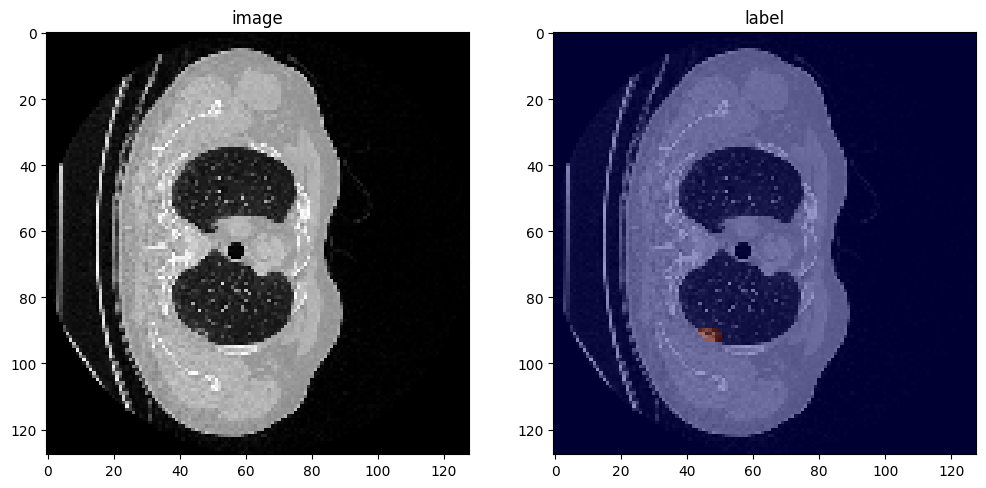

In [ ]:
slide = 50
plt.figure("Training Data", (12, 12))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(training_image[0, 0, :, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(training_image[0, 0, :, :, slide], cmap = "gray")
plt.imshow(training_label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.4)

plt.show()

## Load validation set

In [ ]:
# Set up transform
val_transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys = KEYS, pixdim = (1., 1., 1.), mode = ('bilinear', 'nearest')),
    ScaleIntensityD(keys = "image"),
    ResizeD(KEYS, (128, 128, 64), mode=('trilinear', 'nearest')),
    ToTensorD(KEYS),
])

# Load data
val_dataset = DecathlonDataset(root_dir = "./",
                           task = "Task06_Lung", section = "validation",
                           transform = val_transform, download = True)

val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = True, num_workers = 4)

2023-04-15 05:29:22,154 - INFO - Verified 'Task06_Lung.tar', md5: 8afd997733c7fc0432f71255ba4e52dc.
2023-04-15 05:29:22,156 - INFO - File exists: Task06_Lung.tar, skipped downloading.
2023-04-15 05:29:22,158 - INFO - Non-empty folder exists in Task06_Lung, skipped extracting.


Loading dataset: 100%|██████████| 12/12 [03:16<00:00, 16.35s/it]


In [ ]:
#change transform here
val_transform = Compose([
    LoadImageD(keys=KEYS),
    EnsureChannelFirstD(keys=KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    SpacingD(keys=KEYS, pixdim=(1., 1., 1.), mode=('bilinear', 'nearest')),
    ScaleIntensityD(keys="image"),
    CropForegroundD(keys=KEYS, source_key="image"),
    CenterSpatialCropD(KEYS, roi_size=(128, 128, 64)),
    ToTensorD(KEYS),
])

In [ ]:
# Check transformed data
print(f"Length of validation set: {len(val_loader)}")

check_val = first(val_loader)
val_image, val_label = check_val['image'], check_val['label']
print(f"check data image shape: {val_image.shape} \ncheck data label shape: {val_label.shape}")

Length of validation set: 12
check data image shape: torch.Size([1, 1, 128, 128, 64]) 
check data label shape: torch.Size([1, 1, 128, 128, 64])


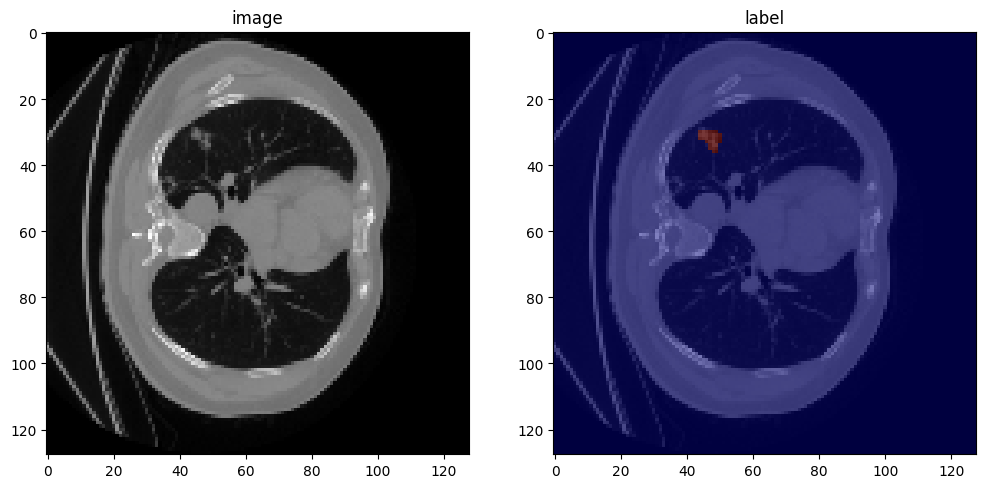

In [ ]:
slide = 29
plt.figure("Validation Data", (12, 12))

plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(val_image[0, 0, :, :, slide], cmap = "gray")

plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(val_image[0, 0, :, :, slide], cmap = "gray")
plt.imshow(val_label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

plt.show()

# Model, Loss, Optimizer

In [46]:
device = torch.device("cuda:0")

UNet_metadata = dict(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 2,
    channels = (64, 128, 256, 512),
    strides = (2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
)

model = UNet(**UNet_metadata).to(device) # using UNet model

loss_function = DiceLoss(include_background = False, to_onehot_y = True, softmax = True) # using Dice Loss function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # using Adam optimizer
dice_metric = DiceMetric(include_background = False, reduction = "mean")

In [45]:
#change unet here
from monai.networks.nets import UNETR
model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(128, 128, 64),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)




loss_function = DiceLoss(include_background = False, to_onehot_y = True, softmax = True) # using Dice Loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
dice_metric = DiceMetric(include_background = False, reduction = "mean")

OptionalImportError: ignored

# Start training

In [47]:
max_epochs = 100
val_interval = 1
best_metric = -1
best_metric_epoch = -1
metric_values = []
epoch_loss_values = []
post_pred = Compose([AsDiscrete(argmax = True, to_onehot = 2)])
post_label = Compose([AsDiscrete(to_onehot = 2)])

for epoch in range(max_epochs):
  print("-" * 12)
  print(f"Epoch {epoch + 1}/{max_epochs}")

  # Turn model to "train" mode
  model.train()

  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
    step += 1

    input, label = (
        batch_data["image"].to(device),
        batch_data["label"].to(device),
    )

    # A common pytorch Deep Learning format to train model
    optimizer.zero_grad()
    output = model(input)
    loss = loss_function(output, label)
    loss.backward() # Compute gradient
    optimizer.step() # Update model's parameters

    epoch_loss += loss.item()
    print(f"{step}/{len(dataset) // train_loader.batch_size}, "
          f"train_loss: {loss.item():.4f}")
    
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)

  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  if (epoch + 1) % val_interval == 0:
    # Turn model to "eval" mode
    model.eval() 

    # Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). 
    # It will reduce memory consumption for computations that would otherwise have requires_grad=True
    with torch.no_grad():
      for val_data in val_loader:
        val_input, val_label = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        roi_size = (128, 128, 96)
        sw_batch_size = 1

        # Set AMP for MONAI validation
        val_output = sliding_window_inference(
            val_input, roi_size, sw_batch_size, model
        )
        val_output = [post_pred(i) for i in decollate_batch(val_output)]
        val_label = [post_label(i) for i in decollate_batch(val_label)]

        # Compute metric for current iteration
        dice_metric(y_pred = val_output, y = val_label)

      # Aggregate the final mean dice result
      metric = dice_metric.aggregate().item()

      # Reset the status for the next epoch
      dice_metric.reset()

      metric_values.append(metric)
      if metric > best_metric:
        best_metric = metric
        best_metric_epoch = epoch + 1
        print("saved new best metric model!!!")
        torch.save(model.state_dict(), "best_metric_model.pth")
      
      print(
          f"current epoch: {epoch + 1},"
          f" current mean dice: {metric:.4f},"
          f" best mean dice: {best_metric:.4f},"
          f" at epoch: {best_metric_epoch}"
      )

print(
    f"train completed, best metric: {best_metric:.4f}"
    f" at epoch: {best_metric_epoch}"
)

Streaming output truncated to the last 5000 lines.
9/51, train_loss: 0.6964
10/51, train_loss: 1.0000
11/51, train_loss: 0.8303
12/51, train_loss: 0.9661
13/51, train_loss: 0.9309
14/51, train_loss: 0.8904
15/51, train_loss: 0.7226
16/51, train_loss: 0.9991
17/51, train_loss: 0.9605
18/51, train_loss: 1.0000
19/51, train_loss: 1.0000
20/51, train_loss: 1.0000
21/51, train_loss: 0.9994
22/51, train_loss: 1.0000
23/51, train_loss: 0.9634
24/51, train_loss: 1.0000
25/51, train_loss: 0.9857
26/51, train_loss: 0.9935
27/51, train_loss: 0.9969
28/51, train_loss: 0.9999
29/51, train_loss: 1.0000
30/51, train_loss: 0.7801
31/51, train_loss: 0.9941
32/51, train_loss: 0.9796
33/51, train_loss: 0.7903
34/51, train_loss: 1.0000
35/51, train_loss: 0.6754
36/51, train_loss: 0.9866
37/51, train_loss: 0.9866
38/51, train_loss: 0.9776
39/51, train_loss: 0.9247
40/51, train_loss: 0.9991
41/51, train_loss: 0.7638
42/51, train_loss: 0.9648
43/51, train_loss: 0.7910
44/51, train_loss: 0.7513
45/51, train_l

In [ ]:
## Define your path below, it will be saed somewhere in your google drive

rootname = '/content/drive/MyDrive'
# PATH_NAME = rootname + *enter your path here*
PATH_NAME = rootname + '/model05lr'

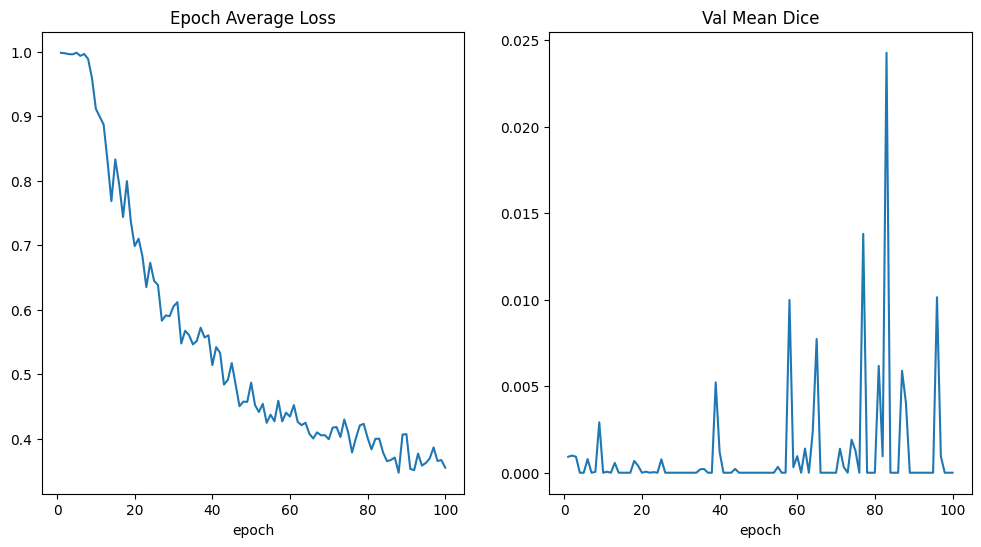

In [48]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig('model_1png')
plt.show()
# plt.savefig(PATH_NAME+'model_graph.png')

# Check model

In [49]:
checker = first(val_loader)
image, label = checker['image'], checker['label']

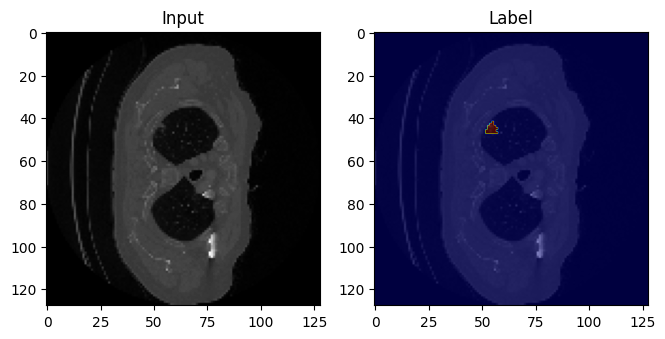

In [67]:
slide = 54
plt.figure("Test Model", (12, 12))

plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(image[0, 0, :, :, slide], cmap = "gray")

plt.subplot(1, 3, 2)
plt.title("Label")
plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
plt.imshow(label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

plt.show()

In [66]:
# plt.figure("Test Model", (12, 12))

# for slide in range(64):
#     plt.subplot(8, 8, slide+1)
#     plt.title("Slide {}".format(slide))
#     plt.imshow(image[0, 0, :, :, slide], cmap="gray")
#     plt.imshow(label[0, 0, :, :, slide], cmap='jet', alpha=0.5)

# plt.tight_layout()
# plt.show()

Output shape: torch.Size([1, 2, 128, 128, 64])


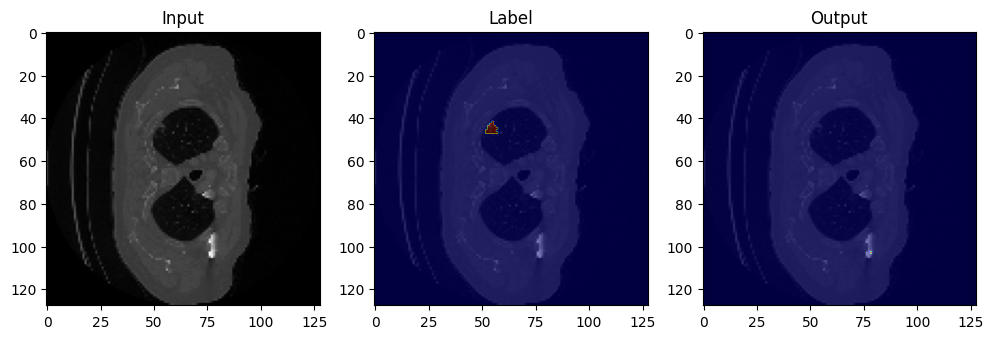

In [68]:
model.cpu()
model.load_state_dict(torch.load("best_metric_model.pth"))

with torch.no_grad():
  output = model(image)
  output = torch.nn.Softmax()(output)
  output = torch.round(output)

  print(f"Output shape: {output.shape}")

  slide = 54
  plt.figure("Test Model", (12, 12))

  plt.subplot(1, 3, 1)
  plt.title("Input")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")

  plt.subplot(1, 3, 2)
  plt.title("Label")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
  plt.imshow(label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

  plt.subplot(1, 3, 3)
  plt.title("Output")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
  plt.imshow(output[0, 1, :, :, slide], cmap = 'jet', alpha = 0.5)

  plt.show()